# Sää ja sähkö


In [128]:
import datetime as dt
import xmltodict
import pandas as pd
from catboost import Pool, CatBoostRegressor
from fmiopendata.wfs import download_stored_query
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (18.7, 8.27)})


def date_range(start_date, end_date, max_days):
    current_date = start_date
    while (end_date - current_date).days >= max_days:
        chunk_end = current_date + dt.timedelta(days=max_days - 1)
        yield (current_date, chunk_end)
        current_date = chunk_end + dt.timedelta(days=1)
    yield (current_date, end_date)

# Weather data

Weather data is collected from [Finnish Meteorological Institute open data](https://en.ilmatieteenlaitos.fi/open-data) with [`fmiopendata`](https://github.com/pnuu/fmiopendata) Python library.


In [2]:
def get_weather_df(
    start_date: dt.date, end_date: dt.date, place: str = "Helsinki"
) -> pd.DataFrame:
    """Fetch weather data between given dates

    Args:
        start_date (dt.date): Start date of requested weather data
        end_date (dt.date): End date of requested weather data
        place (str, optional): Place of requested weather data. Defaults to "Helsinki".
    """
    weather_data = {}
    for start, end in date_range(start_date, end_date, 31):
        start_string = start.strftime("%Y-%m-%d") + "T00:00:00Z"
        end_string = end.strftime("%Y-%m-%d") + "T23:59:59Z"
        data_chunk = download_stored_query(
            "fmi::observations::weather::hourly::multipointcoverage",
            [
                "place=" + place,
                "starttime=" + start_string,
                "endtime=" + end_string,
            ],
        ).data
        weather_data.update(data_chunk)

    dates = []
    air_temperatures = []
    wind_speeds = []
    precipitation_amounts = []
    place_key = list(list(weather_data.values())[0].keys())[0]
    for datetime, data in weather_data.items():
        dates.append(datetime)
        air_temperatures.append(data[place_key]["Air temperature"]["value"])
        wind_speeds.append(data[place_key]["Wind speed"]["value"])
        precipitation_amounts.append(data[place_key]["Precipitation amount"]["value"])

    weather_df = pd.DataFrame(
        {
            "datetime": dates,
            "air temperatures": air_temperatures,
            "wind speeds": wind_speeds,
            "precipitation amounts": precipitation_amounts,
        }
    )

    return weather_df

# Energy data

Energy data is obtained from [ENTSO-E (European Network of Transmission System Operators for Electricity) API](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show).


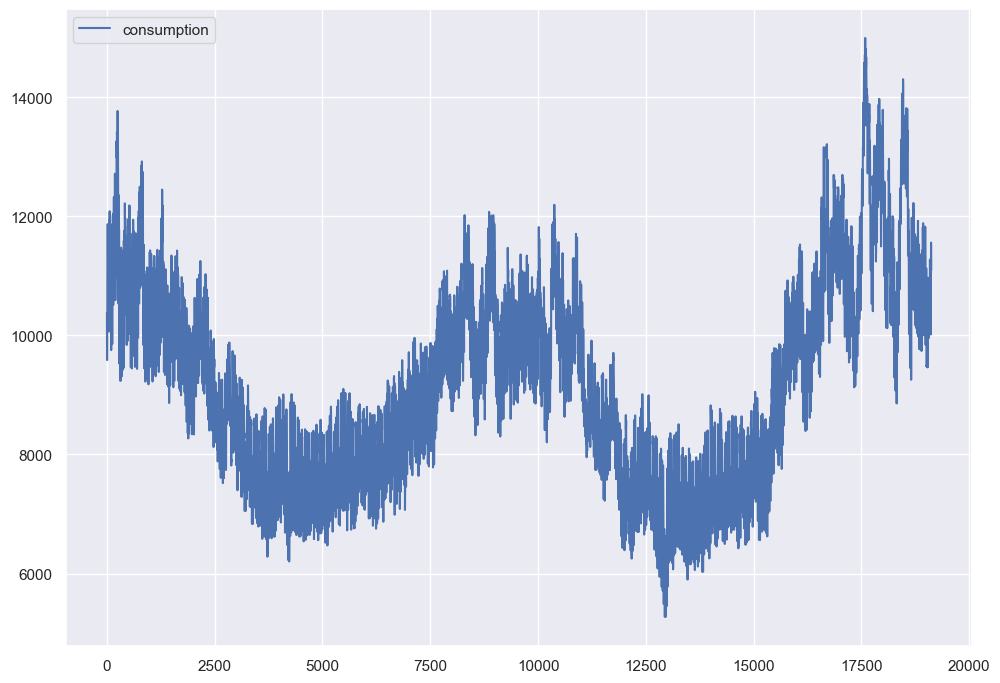

In [3]:
energy_data_years = list(range(2022, 2025))
data = []
for year in energy_data_years:
    with open(f"data/electricity-consumption/{year}.xml", "r") as file:
        data_string = file.read()
        yearly_data = xmltodict.parse(data_string)["GL_MarketDocument"]["TimeSeries"]
        data += yearly_data

energy_data = [day["Period"] for day in data]
hourly_means = {}

times = []
values = []

for day in energy_data:
    time = dt.datetime.strptime(
        day["timeInterval"]["start"], "%Y-%m-%dT%H:%MZ"
    ) + dt.timedelta(hours=2)
    if day["resolution"] == "PT60M":
        for hour in day["Point"]:
            hourly_means[time] = int(hour["quantity"])
            times.append(time)
            values.append(int(hour["quantity"]))
            time += dt.timedelta(hours=1)
    elif day["resolution"] == "PT15M":
        fifteen_min_means = [
            int(fifteen_min["quantity"]) for fifteen_min in day["Point"]
        ]
        i = 0
        while i < len(fifteen_min_means):
            hourly_means[time] = sum(fifteen_min_means[i : i + 4]) / 4
            times.append(time)
            values.append(sum(fifteen_min_means[i : i + 4]) / 4)
            time += dt.timedelta(hours=1)
            i += 4
    else:
        print("Unknown resolution", day["resolution"])

energy_df = pd.DataFrame({"datetime": times, "consumption": values})
# print(energy_df.head())
ax = sns.lineplot(x=energy_df["datetime"], y=energy_df["consumption"])

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Daily energy consumption (MWh)')]

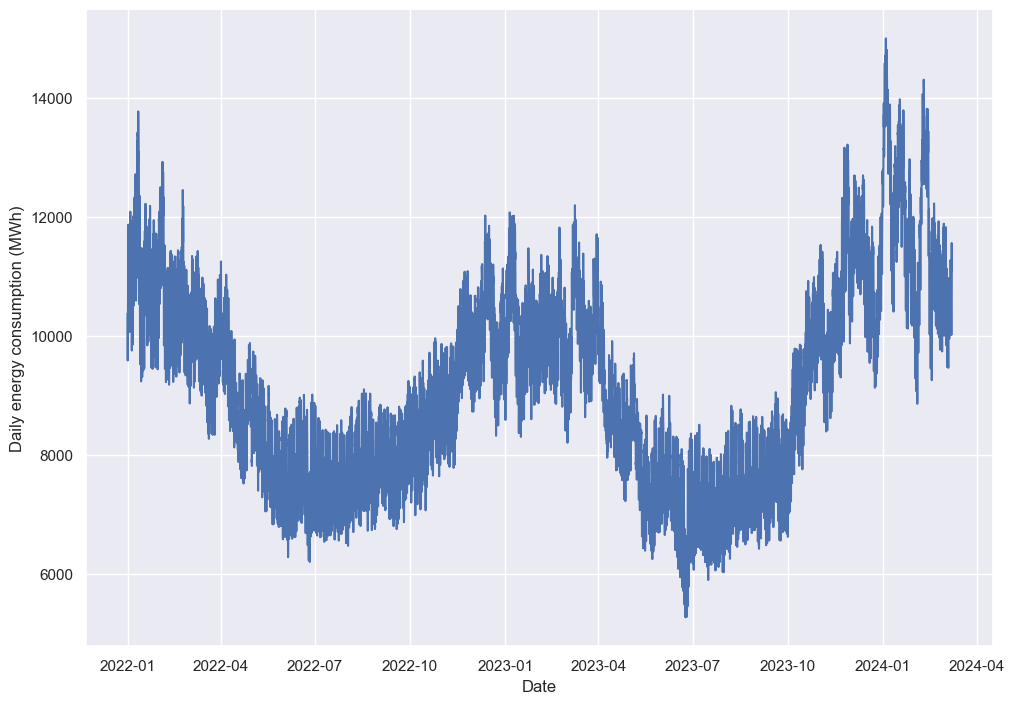

In [18]:
# Polished graph
ax = sns.lineplot(x=energy_df["datetime"], y=energy_df["consumption"])
ax.set(xlabel="Date", ylabel="Daily energy consumption (MWh)")

In [ ]:
# Testing what the get_weather_df gives

start_date = dt.date(2023, 1, 1)
end_date = dt.date(2024, 3, 7)
tw = get_weather_df(start_date, end_date)

In [11]:
tw.describe()

,datetime,air temperatures,wind speeds,precipitation amounts
count,10368,10352.000000,10296.000000,10351.000000
mean,2023-08-04 23:30:00,5.333665,3.945037,0.090078
min,2023-01-01 00:00:00,-21.000000,0.200000,0.000000
25%,2023-04-18 23:45:00,-0.800000,2.600000,0.000000
50%,2023-08-04 23:30:00,3.000000,3.800000,0.000000
75%,2023-11-20 23:15:00,14.400000,5.000000,0.000000
max,2024-03-07 23:00:00,27.700000,12.700000,22.900000
std,NaN,9.404787,1.827491,0.557532


# Predictions

Predictions are made with [CatBoost library](https://catboost.ai/).


In [99]:
start_date = dt.date(2023, 1, 1)
end_date = dt.date(2024, 3, 6)

weather_data1 = get_weather_df(start_date, end_date).set_index("datetime")
weather_data2 = get_weather_df(start_date, end_date, "Kajaani").set_index("datetime")
weather_data3 = get_weather_df(start_date, end_date, "Vaasa").set_index("datetime")
dataframe = weather_data1.join(weather_data2, rsuffix="1").join(
    weather_data3, rsuffix="2"
)
dataframe = dataframe.loc[
    :,
    [
        "air temperatures",
        "air temperatures1",
        "air temperatures2",
        "wind speeds",
        "precipitation amounts",
    ],
]
dataframe["weekday"] = dataframe.index.weekday

In [106]:
train_data = dataframe.iloc[: int(0.8 * len(dataframe))]
test_data = dataframe.iloc[int(0.8 * len(dataframe)) :]
train_labels = [hourly_means[time] for time in train_data.index]
train_pool = Pool(train_data, train_labels, cat_features=["weekday"])
test_pool = Pool(test_data, cat_features=["weekday"])

model = CatBoostRegressor(iterations=19, depth=6, loss_function="RMSE")
model.fit(train_pool)
predictions = model.predict(test_pool)

print(predictions)

Learning rate set to 0.5
0:	learn: 1019.4633584	total: 3.62ms	remaining: 65.1ms
1:	learn: 822.4344826	total: 5.18ms	remaining: 44ms
2:	learn: 752.0693423	total: 6.76ms	remaining: 36.1ms
3:	learn: 725.2740148	total: 9.85ms	remaining: 36.9ms
4:	learn: 701.7098268	total: 11.6ms	remaining: 32.4ms
5:	learn: 689.0474546	total: 12.8ms	remaining: 27.7ms
6:	learn: 680.9548838	total: 13.9ms	remaining: 23.8ms
7:	learn: 677.0414414	total: 15.4ms	remaining: 21.1ms
8:	learn: 674.4504955	total: 16.8ms	remaining: 18.7ms
9:	learn: 667.5500705	total: 18.1ms	remaining: 16.3ms
10:	learn: 663.7762918	total: 19.5ms	remaining: 14.2ms
11:	learn: 660.9078743	total: 21.4ms	remaining: 12.5ms
12:	learn: 658.8212708	total: 23.6ms	remaining: 10.9ms
13:	learn: 657.2495140	total: 24.8ms	remaining: 8.84ms
14:	learn: 654.1232409	total: 26ms	remaining: 6.94ms
15:	learn: 651.7429884	total: 27.4ms	remaining: 5.14ms
16:	learn: 650.4433231	total: 28.9ms	remaining: 3.4ms
17:	learn: 647.1448409	total: 30.2ms	remaining: 1.68ms

In [101]:
# forecast accuracy with MAPE

# mape results
# Helsinki 2024: (iterations=2, depth=2, loss_function="RMSE") -> 0.04859686603768826
# 3 weather points 2024: dataset: (18, 1, 'RMSE') = 0.050754643819194256
# 3 weather points 2024 v2: (19, 4, 'RMSE') = 0.05170260585403051
# 3 points, 2023-2024: (19, 6, 'RMSE') = 0.0961433526352825

mapes = {}

actual = [hourly_means[time] for time in test_data.index]

for i in range(1, 20):
    for k in range(10):
        for l in ["RMSE", "MAE"]:
            model = CatBoostRegressor(iterations=i, depth=k, loss_function=l)
            model.fit(train_pool)
            predictions = model.predict(test_pool)

            mape = 0
            for p in range(len(predictions)):
                mape += abs((actual[p] - predictions[p]) / actual[p]) / len(predictions)

            # print(f"{mape = }")
            mapes[(i, k, l)] = mape

Learning rate set to 0.5
0:	learn: 1514.6069817	total: 707us	remaining: 0us
0:	learn: 1285.5438056	total: 987us	remaining: 0us
Learning rate set to 0.5
0:	learn: 1095.0838573	total: 814us	remaining: 0us
0:	learn: 1255.8547743	total: 1.42ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1051.2900600	total: 830us	remaining: 0us
0:	learn: 1254.5867652	total: 1.36ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1038.5719081	total: 1.59ms	remaining: 0us
0:	learn: 1254.5778713	total: 1.39ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1029.8789718	total: 1.16ms	remaining: 0us
0:	learn: 1253.8111831	total: 1.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1029.9517667	total: 1.53ms	remaining: 0us
0:	learn: 1253.2470728	total: 1.75ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1019.4633584	total: 1.56ms	remaining: 0us
0:	learn: 1252.6514463	total: 2.17ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1009.8756483	total: 2.44ms	remaining: 0us
0:	learn: 1252.3896538	to

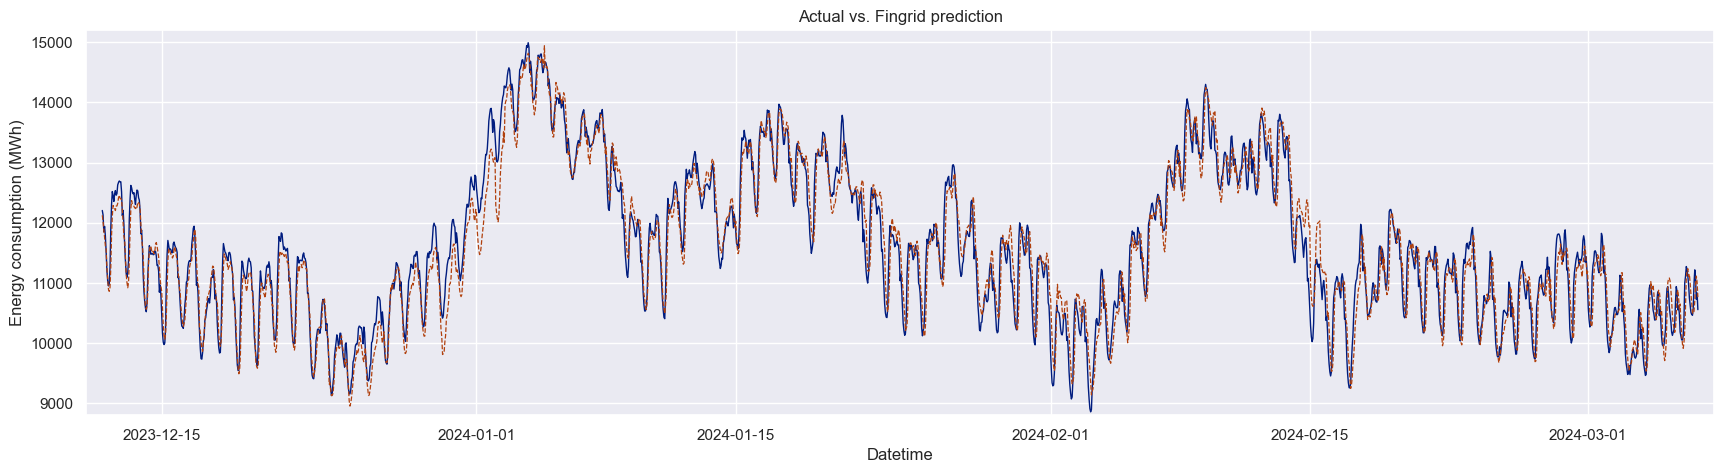

In [167]:
# print(train_data.shape)
# print(train_data.columns)
# print(len(train_labels))
# print(type(train_labels))
# print()

dr = pd.date_range(test_data.index.min(), test_data.index.max(), freq="h")
# print(test_data.index.min())
# print(test_data.index.max())
# print(dr)
# print(len(dr))
# print()
# print(type(actual))
# print(len(actual))
# print(len(predictions))

# fin_pred = pd.read_csv("./data/165_2024-02-22T1900_2024-03-06T2300.csv", sep=",")
fin_pred = pd.read_csv("./data/165_2023-12-11T1900_2024-03-06T2300.csv", sep=",")
# print(fin_pred.describe())
# print(fin_pred.columns)

sns.set_palette("dark", 2)
ax = sns.lineplot(x=dr, y=actual, lw=1)
# ax = sns.lineplot(x=dr, y=predictions, lw=0.7)
ax = sns.lineplot(
    x=dr, y=fin_pred["consumption prediction"], data=fin_pred, linestyle="--", lw=0.9
)
# ax.set(title="Actual vs. Our prediction", xlabel="Datetime", ylabel="Energy consumption (MWh)", ylim=(8800,15200))
ax.set(
    title="Actual vs. Fingrid prediction",
    xlabel="Datetime",
    ylabel="Energy consumption (MWh)",
    ylim=(8800, 15200),
)

ax.figure.set_size_inches(21, 5)
ax.margins(0.01)

In [168]:
# locate the smallest mean absolute percentage error
print(f"{min(mapes, key=mapes.get)} = {mapes[min(mapes, key=mapes.get)]}")


# Fingrid prediction accuracy
mapef = 0
for fp in range(len(fin_pred)):
    mapef += abs((actual[p] - fin_pred["consumption prediction"][p]) / actual[p]) / len(
        fin_pred
    )
print(mapef)

(19, 6, 'RMSE') = 0.0961433526352825
0.019667471934062507


In [ ]:
# joining the weather and consumption data

train_weather = get_weather_df(dt.date(2023, 1, 1), dt.date(2023, 12, 31))

train_data = train_weather.set_index("datetime").join(energy_df.set_index("datetime"))